In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [3]:
train_dir = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/Week 5/FruitinAmazon/test"

In [4]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['graviola', 'cupuacu', 'acai', 'guarana', 'tucuma', 'pupunha']


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


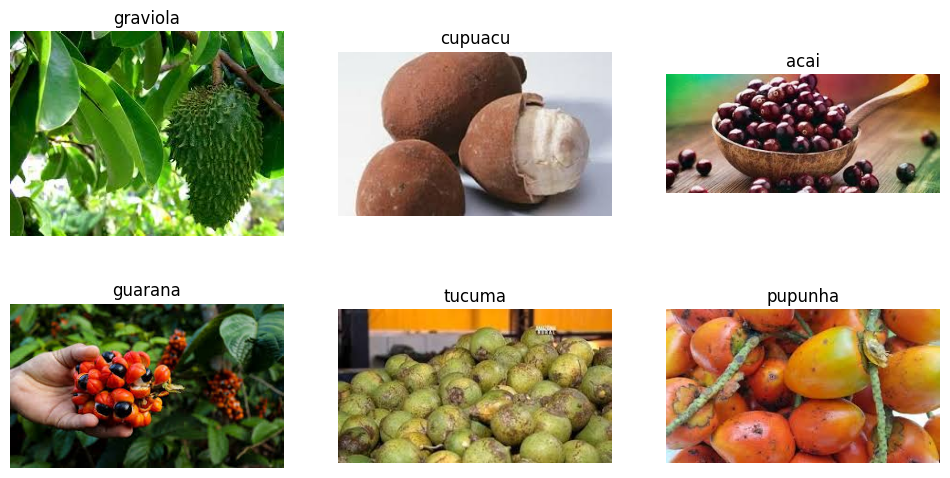

In [6]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [7]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")


No Damaged Images Found.


In [8]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [10]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [11]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [12]:

num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.1655 - loss: 2.1212

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 613ms/step - accuracy: 0.1623 - loss: 2.1668 - val_accuracy: 0.2222 - val_loss: 1.4489
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 794ms/step - accuracy: 0.2578 - loss: 1.7457 - val_accuracy: 0.0556 - val_loss: 1.7337
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.2587 - loss: 1.6795

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 760ms/step - accuracy: 0.2669 - loss: 1.6772 - val_accuracy: 0.4444 - val_loss: 1.6176
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.4262 - loss: 1.5757 - val_accuracy: 0.2222 - val_loss: 1.6628
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2922 - loss: 1.4860

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - accuracy: 0.3095 - loss: 1.4785 - val_accuracy: 0.5000 - val_loss: 1.4131
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.6584 - loss: 1.2742 - val_accuracy: 0.1667 - val_loss: 1.6976
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.6584 - loss: 1.1292 - val_accuracy: 0.2778 - val_loss: 1.2969
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6551 - loss: 0.9499

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.6545 - loss: 0.9449 - val_accuracy: 0.7778 - val_loss: 0.8603
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 796ms/step - accuracy: 0.6918 - loss: 0.7578 - val_accuracy: 0.6667 - val_loss: 1.0254
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 0.8602 - loss: 0.6571 - val_accuracy: 0.6667 - val_loss: 0.8117
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step - accuracy: 0.9340 - loss: 0.4476 - val_accuracy: 0.7778 - val_loss: 0.9371
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8744 - loss: 0.3623

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step - accuracy: 0.8780 - loss: 0.3612 - val_accuracy: 0.8333 - val_loss: 0.6312
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9653 - loss: 0.2329

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - accuracy: 0.9635 - loss: 0.2310 - val_accuracy: 0.8889 - val_loss: 0.5352
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.9813 - loss: 0.1590 - val_accuracy: 0.8333 - val_loss: 0.4822
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - accuracy: 0.9813 - loss: 0.0969 - val_accuracy: 0.8333 - val_loss: 0.5833
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step - accuracy: 1.0000 - loss: 0.0793 - val_accuracy: 0.8333 - val_loss: 0.4950
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 1.0000 - loss: 0.0351 - val_accuracy: 0.8333 - val_loss: 0.3210
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 1.0000 - loss: 0.0330

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 1.0000 - loss: 0.0330 - val_accuracy: 0.9444 - val_loss: 0.2600
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 466ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.8889 - val_loss: 0.4125
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 0.8889 - val_loss: 0.4248
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 758ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8333 - val_loss: 0.4522
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8889 - val_loss: 0.4512
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.8333 - val_loss: 0.9266
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.9627 - loss: 0.1056 - val_accuracy: 0.7778 - val_loss: 0.6513
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step - accuracy: 0.9931 - loss: 0.0500 - val_accuracy: 0.8889 - val_lo

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.6333 - loss: 0.9268
Test Accuracy: 63.33%


In [16]:

model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
              precision    recall  f1-score   support

    graviola       0.75      0.60      0.67         5
     cupuacu       1.00      0.40      0.57         5
        acai       0.71      1.00      0.83         5
     guarana       0.40      0.80      0.53         5
      tucuma       0.75      0.60      0.67         5
     pupunha       0.67      0.40      0.50         5

    accuracy                           0.63        30
   macro avg       0.71      0.63      0.63        30
weighted avg       0.71      0.63      0.63        30



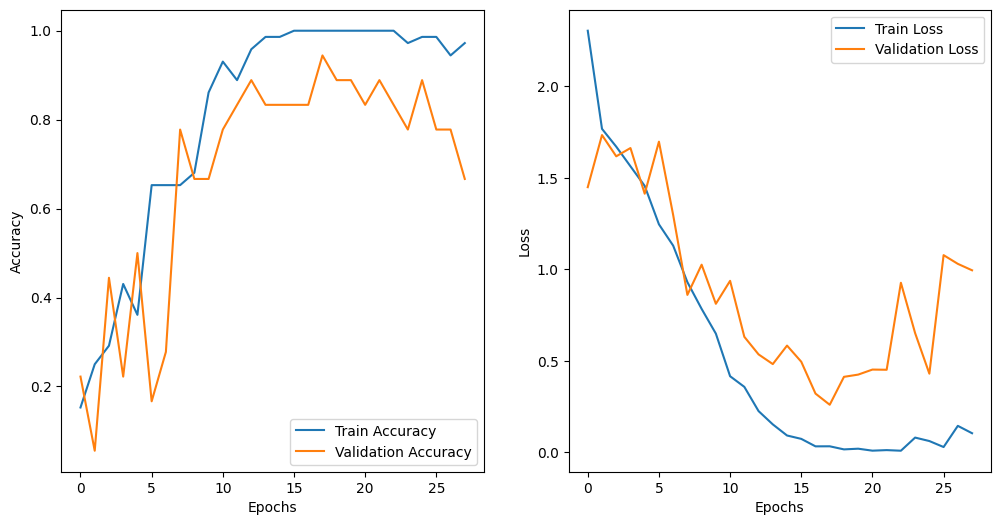

In [18]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()